# Model 1_1
## Dataset: Gym

## Programmer: Giovanni Vecchione
## Date: 4/17/24
## Subject: Machine Learning 2 - Project 6
Use Reinforced Learning (RL) to build the project. Submit your project as Jupyter notebook.

In [54]:
import matplotlib as mtp
import torch

In [55]:
#Checks if GPU is being used
if torch.cuda.is_available():
    device = torch.device("cuda")  # Use the GPU
    print("Using GPU:", torch.cuda.get_device_name(0)) 
else:
    device = torch.device("cpu")  # Fallback to CPU
    print("GPU not available, using CPU.")

#Using GPU: NVIDIA GeForce GTX 1660 SUPER - Successful
#NOTE: This took some time to set up by installing and pathing the cuda toolkit v.12.4 and the right supplemental packages. This drastically improved
#training time

Using GPU: NVIDIA GeForce GTX 1660 SUPER


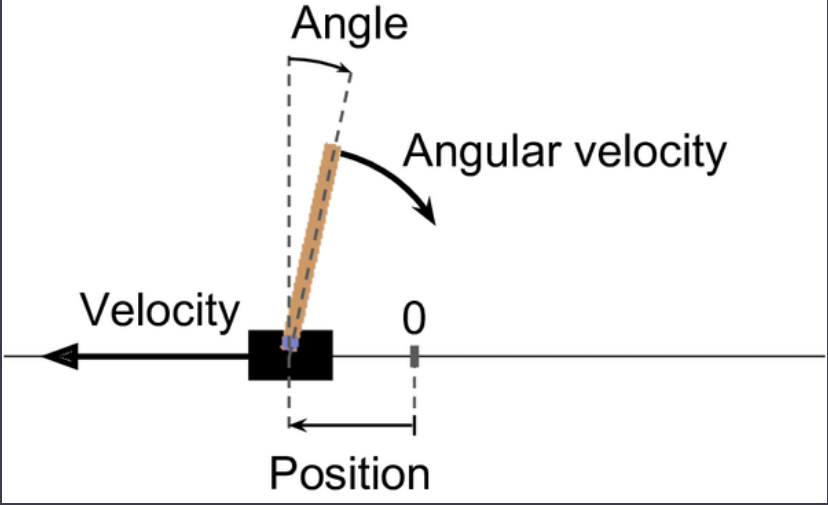

The CartPole Enviornment

After the environment is created, you must initialize it using the reset() method, optionally specifying a random seed. This returns the first observation. Observations depend on the type of environment. For the CartPole environment, each observation is a 1D NumPy array containing four floats representing the cart's horizontal position (0.0 = center), its velocity (positive means right), the angle of the pole (0.0 = vertical), and its angular velocity (positive means clockwise). The reset() method also returns a dictionary that may contain extra environment-specific information. This can be useful for debugging or for training. For example, in many Atari environments, it contains the number of lives left. However, in the CartPole environment, this dictionary is empty.

In [56]:
import gym

env = gym.make("CartPole-v1", render_mode="rgb_array")
#render_mode="rgb_array" dosn't work for some reason when using the render call

In [57]:
print(env.observation_space)    # See what kind of data the environment provides
print(env.action_space)         # See the agent's possible actions 

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Discrete(2)


In [58]:
obs, info = env.reset(seed=42)
obs


array([ 0.0273956 , -0.00611216,  0.03585979,  0.0197368 ], dtype=float32)

1. obs

When you print obs, you'll likely see an array of numbers. In the case of CartPole, it should be a 4-element array representing:
Cart position
Cart velocity
Pole angle
Pole angular velocity

In [59]:
info

{}

2. info

Printing info will display the dictionary. The content varies from environment to environment.

In [60]:
img = env.render()
img.shape #only works when using hte rgb call from earlier, however it does not seem to function


(400, 600, 3)

In [61]:
action = 1  # accelerate right
obs, reward, done, truncated, info = env.step(action)

c:\Users\GioDude\AppData\Local\Programs\Python\Python311\Lib\site-packages\gym\utils\passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


## The step() method executes the desired action and returns five values:

### *1. obs*
    This is the new observation. The cart is now moving toward the right (obs[1] > 0). The pole is still tilted toward the right (obs[2] > 0), but its angular velocity is now negative (obs[3] < 0), so it will likely be tilted toward the left after the next step.

### *2. reward*
    In this environment, you get a reward of 1.0 at every step, no matter what you do, so the goal is to keep the episode running for as long as possible.

### *3. done*
    This value will be True when the episode is over. This will happen when the pole tilts too much, or goes off the screen, or after 200 steps (in this last case, you have won). After that, the environment must be reset before it can be used again.

### *4. truncated*
    This value will be True when an episode is interrupted early, for example by an environment wrapper that imposes a maximum number of steps per episode (see Gym's documentation for more details on environment wrappers). Some RL algorithms treat truncated episodes differently from episodes finished normally (i.e., when done is True), but in this chapter we will treat them identically.

### *5. info*
    This environment-specific dictionary may provide extra information, just like the one returned by the reset() method.

In [62]:
obs

array([ 0.02727336,  0.18847767,  0.03625453, -0.26141977], dtype=float32)

In [63]:
reward

1.0

In [64]:
done

False

In [65]:
truncated

False

In [66]:
info

{}

### NOTE: Once you have finished using an environment, you should call its close() method to free resources.

## We will run this policy to see the average rewards it gets over 500 episodes:

In [67]:
def basic_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset(seed=episode)
    for step in range(200):
        action = basic_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done or truncated:
            break

    totals.append(episode_rewards)

In [68]:
import numpy as np
np.mean(totals), np.std(totals), min(totals), max(totals)

#Even with 500 tries, this policy never managed to keep the pole upright for more than 63 consecutive steps. Not great. 

(41.698, 8.389445512070509, 24.0, 63.0)

# Neural Network Policies

This neural network will take an observation as input, and it will output the action to be executed, just like the policy we hardcoded earlier. More precisely, it will estimate a probability for each action, and then we will select an action randomly, according to the estimated probabilities (see Figure 18-5). In the case of the CartPole environment, there are just two possible actions (left or right), so we only need one output neuron. It will output the probability p of action 0 (left), and of course the probability of action 1 (right) will be 1 - p. For example, if it outputs 0.7, then we will pick action 0 with 70% probability, or action 1 with 30% probability.

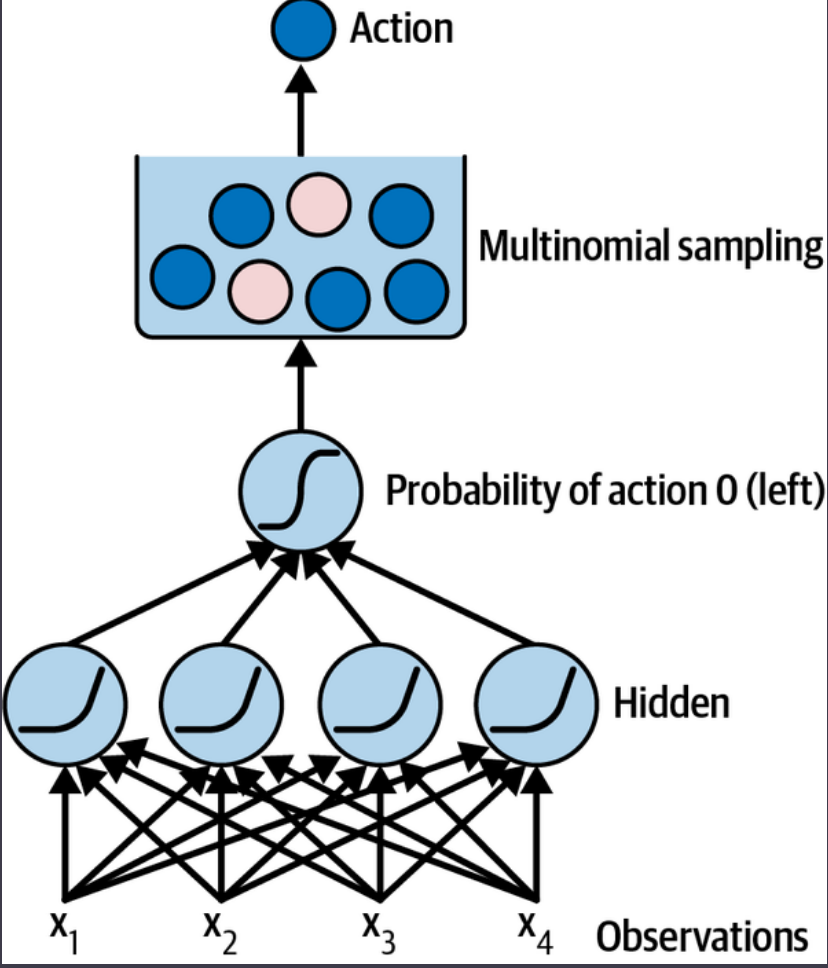

In [69]:
#Here is the code to build a basic neural network policy using Keras:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

We use a Sequential model to define the policy network. The number of inputs is the size of the observation space—which in the case of CartPole is 4—and we have just five hidden units because it's a fairly simple task. Finally, we want to output a single probability—the probability of going left—so we have a single output neuron using the sigmoid activation function. If there were more than two possible actions, there would be one output neuron per action, and we would use the softmax activation function instead.

# The Credit Assignment Problem

In reinforcement learning the only guidance the agent gets is through rewards, and rewards are typically sparse and delayed. For example, if the agent manages to balance the pole for 100 steps, how can it know which of the 100 actions it took were good, and which of them were bad? All it knows is that the pole fell after the last action, but surely this last action is not entirely responsible. This is called the credit assignment problem: when the agent gets a reward, it is hard for it to know which actions should get credited (or blamed) for it.

**Why Credit Assignment is Hard**

* **Delayed Rewards:** In many tasks, the rewards are sparse or only received at the end of a long sequence of actions (e.g., winning or losing a game). It's difficult to pinpoint which specific actions earlier on were truly responsible for the final outcome.
* **Exploration vs. Exploitation:**  Agents need to try new actions (exploration) to discover good strategies, but they also want to take advantage of what they've already learned (exploitation). Finding the right balance is key.

**Techniques for Balancing Rewards**

1. **Discounting:**  The discount factor (`gamma` in Q-Learning) makes future rewards worth less than immediate ones. This helps an agent focus on actions that have more immediate consequences.

2. **Eligibility Traces:** This technique keeps a fading 'trace' of recently visited states. When a reward finally arrives, states in this trace get more 'credit', improving how rewards are assigned back in time.

3. **Advantage Functions (Actor-Critic Methods):**  These methods try to estimate how much better an action is compared to the 'average' action in a state. This helps pinpoint actions that are truly contributing more to the reward.

4. **Hindsight Experience Replay (HER):**  A clever technique particularly good for goal-based environments. Even if an agent fails to reach the goal, it 'pretends' that other achieved states were the goal, creating more learning signals from even unsuccessful attempts.

5. **Reward Shaping:** If you have some domain knowledge, you can sometimes carefully design additional intermediate rewards to guide the agent towards good behavior. This must be done cautiously, as poorly shaped rewards can derail learning.

**Key Points**

* **No single perfect solution:** The best method depends heavily on the nature of your environment and the algorithm you're using.
* **Hyperparameter Tuning:**   Parameters like the discount factor or learning rate play a crucial role in how an agent experiences rewards. 
* **It's an active research area:** Researchers are constantly developing new methods to improve how agents learn from rewards.



## Policy Gradients

Here is one common variant:

First, let the neural network policy play the game several times, and at each step, compute the gradients that would make the chosen action even more likely—but dont apply these gradients yet.

Once you have run several episodes, compute each actions advantage, using the method described in the previous section.

If an action's advantage is positive, it means that the action was probably good, and you want to apply the gradients computed earlier to make the action even more likely to be chosen in the future. However, if the action's advantage is negative, it means the action was probably bad, and you want to apply the opposite gradients to make this action slightly less likely in the future. The solution is to multiply each gradient vector by the corresponding action's advantage.

Finally, compute the mean of all the resulting gradient vectors, and use it to perform a gradient descent step.

In [70]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

Let's walk though this function:

Within the GradientTape block (see Chapter 12), we start by calling the model, giving it a single observation. We reshape the observation so it becomes a batch containing a single instance, as the model expects a batch. This outputs the probability of going left.

Next, we sample a random float between 0 and 1, and we check whether it is greater than left_proba. The action will be False with probability left_proba, or True with probability 1 - left_proba. Once we cast this Boolean to an integer, the action will be 0 (left) or 1 (right) with the appropriate probabilities.

We now define the target probability of going left: it is 1 minus the action (cast to a float). If the action is 0 (left), then the target probability of going left will be 1. If the action is 1 (right), then the target probability will be 0.

Then we compute the loss using the given loss function, and we use the tape to compute the gradient of the loss with regard to the model's trainable variables. Again, these gradients will be tweaked later, before we apply them, depending on how good or bad the action turned out to be.

Finally, we play the selected action, and we return the new observation, the reward, whether the episode is ended or not, whether it is truncated or not, and of course the gradients that we just computed.

In [71]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

This code above returns a list of reward lists: one reward list per episode, containing one reward per step. It also returns a list of gradient lists: one gradient list per episode, each containing one tuple of gradients per step and each tuple containing one gradient tensor per trainable variable.

The algorithm will use the play_multiple_episodes() function to play the game several times (e.g., 10 times), then it will go back and look at all the rewards, discount them, and normalize them. To do that, we need a couple more functions; the first will compute the sum of future discounted rewards at each step, and the second will normalize all these discounted rewards (i.e., the returns) across many episodes by subtracting the mean and dividing by the standard deviation:

In [72]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

The call to discount_rewards() returns exactly what we expect (see Figure 18-6). You can verify that the function discount_and_normalize_rewards() does indeed return the normalized action advantages for each action in both episodes. Notice that the first episode was much worse than the second, so its normalized advantages are all negative; all actions from the first episode would be considered bad, and conversely all actions from the second episode would be considered good.

In [73]:
discount_rewards([10, 0, -50], discount_factor=0.8)

array([-22, -40, -50])

In [74]:
discount_and_normalize_rewards([[10, 0, -50], [10, 20]], discount_factor=0.8)

[array([-0.28435071, -0.86597718, -1.18910299]),
 array([1.26665318, 1.0727777 ])]

In [75]:
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

In [76]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

In [78]:
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)
    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))

At each training iteration, this loop calls the play_multiple_episodes() function, which plays 10 episodes and returns the rewards and gradients for each step in each episode.

Then we call the discount_and_normalize_rewards() function to compute each action's normalized advantage, called the final_reward in this code. This provides a measure of how good or bad each action actually was, in hindsight.

Next, we go through each trainable variable, and for each of them we compute the weighted mean of the gradients for that variable over all episodes and all steps, weighted by the final_reward.

Finally, we apply these mean gradients using the optimizer: the model's trainable variables will be tweaked, and hopefully the policy will be a bit better.


**1. Policy Gradient Methods**

* **Core Idea:**  Directly optimize the policy (the agent's decision-making strategy).
* **Pros:** Can handle continuous action spaces, learn stochastic policies (probabilities of actions).
* **Cons:** Can have high variance (fluctuation) during learning, sometimes less sample efficient.
* **Examples:** REINFORCE, Actor-Critic methods (like A2C, DDPG), Proximal Policy Optimization (PPO)

**2. Markov Decision Processes (MDPs)**

* **Foundation:** MDPs are the mathematical framework underpinning reinforcement learning. They describe the environment (states, actions, rewards, transitions) in a formal way.
* **Key in RL:** Many RL algorithms are based on solving MDPs or estimating components of MDPs.

**3. Temporal Difference (TD) Learning**

* **Learning from Estimates:** TD methods update value estimates based on other *estimates* within the learning process, without needing to wait for the final outcome.
* **Pros:** Often more sample efficient than basic policy gradient methods.
* **Cons:** Can be unstable when combined with function approximation (like using neural networks).
* **Examples:** Sarsa, Q-learning

**4.  Q-Learning**

* **Off-Policy Method:**  Q-learning can learn the optimal policy even while the agent is following a different (e.g., exploratory) behavior policy.  
* **Tabular Method:**  Well suited for environments with smaller state-action spaces.
* **Foundation for Deep Q-Learning** 

**5. Deep Q-Learning (DQN)**

* **Enter Deep Learning:**   DQNs combine Q-learning with deep neural networks. This allows them to handle environments with large or continuous state spaces (like image-based Atari games).
* **Breakthrough:**  DQNs were a major breakthrough in deep reinforcement learning.
* **Challenges:**  Requires careful techniques to stabilize training (e.g., experience replay, target networks). 

**Beyond the Basics**

The field of reinforcement learning is vast and active! There are many more algorithms and variations:

* **Model-based RL:**  These methods try to explicitly learn a model of the environment.
* **Monte-Carlo Methods:**  Learn from full episodes without bootstrapping (using other estimates).
* **Multi-Agent RL:** Dealing with multiple agents interacting with each other.

**Choosing an Algorithm**

The best algorithm depends heavily on your specific problem:

* **State and action space size:**  Tabular Q-Learning won't work for complex image inputs, but DQN might.
* **Continuous vs. discrete actions:** Some methods are better suited for one or the other.
* **Desired output:** Do you want a deterministic policy or one that includes probabilities?

